# Homework #7

This homework will cover a mix of parallelization and running MPI jobs on the cluster.  Hence, some of the problems will require running (short) jobs on Rivanna.

**Group work**:  You do not have to do this as a group, but I would encourage students to perform the scaling test in problem 1 in groups of 2-3 since this will cut down on the jobs run concurrently on the same account.  My worry is that if we all try to run it at once, the jobs may wait in the queue for a long time.  Try to do this problem early in the week to avoid a long wait in the queue!  If you do this as a group, please note who your fellow group members are in the problem below.

In [73]:
# load homework
import homework7 as hw

For performance purposes, Python ignores requests to reimport a module after it has been imported once.  This behavior is not ideal if you are actively developing the module.  You could reset the kernel via the Jupyter lab interface, but the simpler solution is to use the functionality of the `importlib` module as follows.  You can call this anytime you modify homework1.py. 

In [74]:
# reload module if already loaded
import importlib
importlib.reload(hw)

<module 'homework7' from '/Users/swd8g/Box Sync/astrX470/weeks/w9/homework7.py'>

## Problem 1

Let's peform a weak scaling test on Rivanna. We will use my favorite code: Athena++. Now, some of you may be assuming that I keep using/referencing Athena++ simply because I am lazy and that is the code that I know how to use the best. While this is correct on both accounts, another reason for choosing Athena++ is its relative lack of dependence on libraries.  This means that it is one of the easier codes to get up and running fast without having to install dependent software.

Start by logging into Rivanna.  I should have demonstrated this in class, but the command from a Linux machines would be
```
ssh -X swd8g@rivanna.hpc.virginia.edu
```
Obviously, you should replace my username with your username. You should arrive in your home directory.  Recall that you can use the `pwd` command to check your current directory. You should be able clone the public version of athena here
```
git clone https://github.com/PrincetonUniversity/athena.git
```
This should create a directory called athena.  Now configure the code to run the linear_wave test in pure hydrodynamics. The sequence of commands for this follows. First, we load the necessary modules for compilign with mpi:
```
module purge
module load gcc
module load openmpi
```
The purge may not be necessary, but it cannot hurt to get rid of any uneeded loaded modules. You can confirm the modules loaded correctly with
```
module list
```
You should see a few extra modules that were loaded because openmpi and gcc depend on these. You can also see that there are specific default versions of these modules.

Next, we cd into the athena directory, configure the code, and then compile
```
cd athena
python configure.py --prob=linear_wave -mpi
make all
```
The `configure.py` creates a makefile that is then executed by calling `make`. You can speed the process up by using `make -j 8 all`, which will spread the compilation accross multiple processes -- eight in this example.

Now make sure you copy over the `slurm.athena` file that is included in this week's repo.  You can do this by cloning the repo to your home directory on Rivanna or using `scp` to copy it from its location (your computer, the Dell server, etc.) to Rivanna.

You will want to run the jobs from your scratch directory on Rivanna. For me this will be `/scratch/swd8g` since my user id is `swd8g`. So cd to the corresponding directory for your account and make directories for running the scaling test. Then copy the `athinput.linear_wave3d` and `slurm.athena` codes to this directory.
```
cd /scratch/swd8g  (change to your directory)
mkdir scaling
cd scaling
mkdir run01
mkdir run05
mkdir run10
mkdir run20
mkdir run40
cp /home/swd8g/athena/inputs/hydro/athinput.linear_wave3d .
cp /home/swd8g/slurm.athena .
```
Now copy the athinput file and slurm.athena script into each of the run directories.

These jobs should not have to run for very long so 

reate a script for each run and launch the scripts simultaneously or 

If you did the test as a group, list the other group members here:



## Problem 2

For this problem we will solve Poisson's equation using a finite difference relaxation technique. 
$$
\frac{d^2 \phi}{d x^2} = \rho(x).
$$
We will take $\rho$ to be known function of $x$. In this case $\rho = \sin(x)$.
This needs to be supplemented by boundary conditions, which we will specify at $x=0,~1$ as
\begin{eqnarray}
\phi(0) & = & 0, \\
\phi(1) & = & 0.
\end{eqnarray}

I provide a serial implementation below and a file poisson.py which gives the skeleton of an MPI version.  Complete the MPI version of poisson.py and then test it below.

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def error(phi1, phi2):
    """
    Normalized relative change in phi between two iterations
    """
    TINY = 1e-10 # avoids potential NaN
    dphi = np.abs((phi2-phi1)[1:-1]/(0.5*np.abs(phi1+phi2)+TINY)[1:-1])
    return dphi.sum()

def jacobi(phi, x, rho):
    """
    Jacobi iteration update of poisson's equation
    """
    dx = 0.5*(x[2:]-x[:-2])
    phi[1:-1] = 0.5*(phi[:-2] + phi[2:] - dx*dx*rho[1:-1])
    return phi

def rhs(x):
    """
    Function for the right hand side of Poisson equation
    """
    return np.sin(x)

def relax_solution():
    """
    Solve Poisson's equation using relaxation
    """
    # set parameters for iteration
    eps = 1e-7
    itermax = 1000000
    # initialize grid and rhs
    x0 = 0
    x1 = 1
    nx = 82
    x = np.linspace(x0,x1,nx)
    phi = np.zeros(x.size)
    rho = rhs(x)

    err = 10*eps # ensure while executes
    iterations = 0
    while err > eps:
        iterations += 1
        phinew = phi.copy()
        phinew = jacobi(phinew, x, rho)

        err = error(phi, phinew)
        phi = phinew
        if iterations == itermax:
            break
    print("Total iteration: {0} {1:.3e}".format(iterations, err))

    return x, phi

Total iteration: 17677 9.999e-08


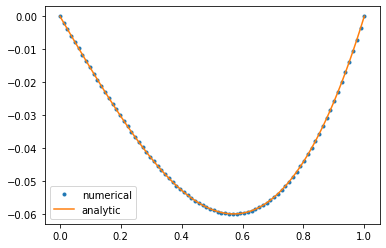

In [98]:
# Compute solution and plot
x, phi = relax_solution()

plt.plot(x, phi, '.',label="numerical")
plt.plot(x,-np.sin(x)+x*np.sin(1), label="analytic")
plt.legend(loc="best")
plt.show()

Now write an MPI version of the code by modifying the `main()` function in `jacobi.py`. We will do this using domain decomposition.

For example, consider a case where we have a grid of 10 point indexed from $i=0,\dots,9$. The $i=0,9$ points represent the fixed boundaries of the global grid and the calculation updates points $i=1,\dots,8$. Now imagine we split this grid in two parts with process 0 update $i=1,2,3,4$ and process 1 updating $i=5,6,7,8$. On both processes we create a grid of *six* points (indexed by $j=0,\dots,5$).

For process 0, the $j=0$ point is still the fixed boundary, $j=1,\dots,4$ are the global $i=1,2,3,4$ and point $j=5$ is a location to store a copy of the point corresponding to $i=5$ on the global grid, which is on process 1. For process 0, the $j=0$ point is the global $i=4$, which is stored as $j=4$ on process 0, points $j=1,\dots,4$ are the global $i=5,6,7,8$ and point $j=5$ is the fixed boundary corresponding to $i=9$. Of course, we can generalize this to a larger number of processes, particularly if we have more points.  This is easiest if the global grid (minus the fixed endpoints) is divisble by the number MPI processes used so that each local grid is the same size.

But how do we set $j=5$ on process 0 and $j=0$ on proccess 1?  You will need to use MPI to communicate them after each iteration.  You can do this using blocking communcation `Send()` and `Recv()`. Process 0 will send its $j=4$ to process 1 and process 1 will store it in its $j=0$. Process 1 will send $j=1$ and process 0 will store it in its $j=5$ Since the endpoints continue to *not* be updated on the local grid, the `jacobi()` function does not need to be changed from the above implementation.

Now try implementing this in the `main()` function of `jacobi.py`.  I have given you the skeleton of the code which works with 1 process:

In [99]:
import subprocess
subprocess.run(["mpirun","-np","1","python","jacobi.py"])

Total iteration: 17677 9.999e-08
Time with 1 processors: 2.750080e-01


CompletedProcess(args=['mpirun', '-np', '1', 'python', 'jacobi.py'], returncode=0)

This should take the same number of iterations as above and will produce a file called `jacobi.png` that should look like the one above.  Now modify the `main()` fucntion to work with multiple processes and try four processes below.

In [100]:
import subprocess
subprocess.run(["mpirun","-np","4","python","jacobi.py"])

Total iteration: 17677 9.999e-08
Time with 4 processors: 1.092837e+00


CompletedProcess(args=['mpirun', '-np', '4', 'python', 'jacobi.py'], returncode=0)

If you did this correctly, it should take the exact same number of iterations and procude an identical plot to what you obtain with a single process.  You will also likely find that it takes **longer** to run! What a bummer -- all that work and it is slower. This is because we are not really doing enough work in our `jacobi` function to overcome the latency and overhead associated with the communication.  We need to do more work per send/receive than we can easily do with such a simple 1D problem. We could, of course, make the array larger e.g. 8002 rather than 82, but it turns out that the size of the array impacts the rate of convergence and signifcantly increase the numer of iterations required so I would not recommend pursuing this approach.

## Problem 3

Recall that when we first implemented iterative solutions of matrix equations, we discussed both the Jacobi method and the Gauss-Seidel method, with Gauss-Seidel being faster because it incorporates new information.  At the time I mentioned that Jacobi is sometime still used because it parallelizes more efficiently.  The problem with Gauss-Seidel is that you need to incorporate new information (which may be on the other process) to make it converge more efficiently.

In order to get around this, we can use a method called Red-Black Gauss-Seidel.  This is a two step method, where you only update every other cell/point in the grid on each substep. For example in 1D, you would first update $i=0,2,4,\dots$ and then on the next step $i=1,3,5,\dots$.  In 2D this looks like a checkerboard patter -- hence the name red-black Guass-Seidel.

Let's try this on our current 1D problem.

In [96]:
import subprocess
subprocess.run(["mpirun","-np","1","python","gaussseidel.py"])

Traceback (most recent call last):
  File "gaussseidel.py", line 122, in <module>
    main()
  File "gaussseidel.py", line 86, in main
    phinew = gaussseidel_black(phinew, x, rho)
NameError: name 'gaussseidel_black' is not defined


CompletedProcess(args=['mpirun', '-np', '1', 'python', 'gaussseidel.py'], returncode=1)